In [1]:
!pip install -U ultralytics --no-deps -q

import os
import shutil
import random
import cv2
import yaml
import glob
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import ultralytics
from ultralytics import YOLO
from pathlib import Path
from tqdm.notebook import tqdm

print(f"Ultralytics Version: {ultralytics.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.4 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics Version: 8.3.237
CUDA Available: True


In [2]:
# --- Configuration ---
SEED = 42
img_size = 640
# MixMatch uses "Label Guessing" (Averaging K augments). 
#  TTA for averaging, for softer threshold than FixMatch.
MIXMATCH_THRESHOLD = 0.75  
device = 0 

# Original Paths
ORIG_TRAIN_IMG = '/kaggle/input/pillsegmentation/train/images'
ORIG_TRAIN_LBL = '/kaggle/input/pillsegmentation/train/labels'
ORIG_VAL_IMG = '/kaggle/input/pillsegmentation/valid/images'
ORIG_TEST_IMG = '/kaggle/input/pillsegmentation/test/images'

# Working Directory Paths
WORK_DIR = '/kaggle/working/dataset_mixmatch'
LABELED_DIR = os.path.join(WORK_DIR, 'labeled_20')
UNLABELED_DIR = os.path.join(WORK_DIR, 'unlabeled_80')
PSEUDO_DIR = os.path.join(WORK_DIR, 'mixmatch_combined')

# Create Directories
for d in [LABELED_DIR, UNLABELED_DIR, PSEUDO_DIR]:
    os.makedirs(os.path.join(d, 'images'), exist_ok=True)
    os.makedirs(os.path.join(d, 'labels'), exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(SEED)
print("Setup & MixMatch Configuration Complete.")

Setup & MixMatch Configuration Complete.


In [3]:
def preprocess_and_save(img_path, save_path):
    """Reads image, applies CLAHE (Contrast), saves to new location."""
    img = cv2.imread(img_path)
    if img is None: return False
    
    # Convert to LAB, apply CLAHE to L-channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    cv2.imwrite(save_path, final)
    return True

In [4]:
# --- Splitting Logic ---
all_train_images = sorted(glob.glob(os.path.join(ORIG_TRAIN_IMG, '*')))
random.shuffle(all_train_images)

split_idx = int(len(all_train_images) * 0.2) # 20% Labeled
labeled_imgs = all_train_images[:split_idx]
unlabeled_imgs = all_train_images[split_idx:]

print(f"Total Images: {len(all_train_images)}")
print(f"Labeled (Teacher Train): {len(labeled_imgs)}")
print(f"Unlabeled (For MixMatch): {len(unlabeled_imgs)}")

Total Images: 6549
Labeled (Teacher Train): 1309
Unlabeled (For MixMatch): 5240


In [5]:
print("Processing Labeled Data...")
for img_path in tqdm(labeled_imgs):
    basename = os.path.basename(img_path)
    lbl_name = basename.rsplit('.', 1)[0] + '.txt'
    src_lbl = os.path.join(ORIG_TRAIN_LBL, lbl_name)
    
    preprocess_and_save(img_path, os.path.join(LABELED_DIR, 'images', basename))
    if os.path.exists(src_lbl):
        shutil.copy(src_lbl, os.path.join(LABELED_DIR, 'labels', lbl_name))

Processing Labeled Data...


  0%|          | 0/1309 [00:00<?, ?it/s]

In [6]:
print("Processing Unlabeled Data...")
for img_path in tqdm(unlabeled_imgs):
    basename = os.path.basename(img_path)
    preprocess_and_save(img_path, os.path.join(UNLABELED_DIR, 'images', basename))

Processing Unlabeled Data...


  0%|          | 0/5240 [00:00<?, ?it/s]

In [7]:
# 1. Clear old cache
for cache_file in glob.glob(os.path.join(LABELED_DIR, 'labels', '*.cache')):
    if os.path.exists(cache_file): os.remove(cache_file)

# 2. Teacher YAML
teacher_yaml = {
    'path': WORK_DIR,
    'train': os.path.join(LABELED_DIR, 'images'),
    'val': ORIG_VAL_IMG,
    'test': ORIG_TEST_IMG,
    'names': {0: 'pill'} 
}
with open('teacher_data.yaml', 'w') as f:
    yaml.dump(teacher_yaml, f)

# 3. Train Teacher
print("--- Starting Teacher Training (20% Data) ---")
teacher_model = YOLO('yolov8s-seg.pt') 

teacher_results = teacher_model.train(
    data='teacher_data.yaml',
    epochs=25,
    imgsz=img_size,
    batch=16,
    patience=10,
    project='mixmatch_project',
    name='teacher_run',
    exist_ok=True,
    augment=True, 
    workers=0,      
    cache=False,    
    amp=False,      
    verbose=True
)
print("Teacher Training Finished.")

--- Starting Teacher Training (20% Data) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=teacher_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.967      0.969      0.983      0.961      0.968      0.971      0.984       0.91
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/mixmatch_project/teacher_run
Teacher Training Finished.


Checking Teacher Segmentations on Test Data...


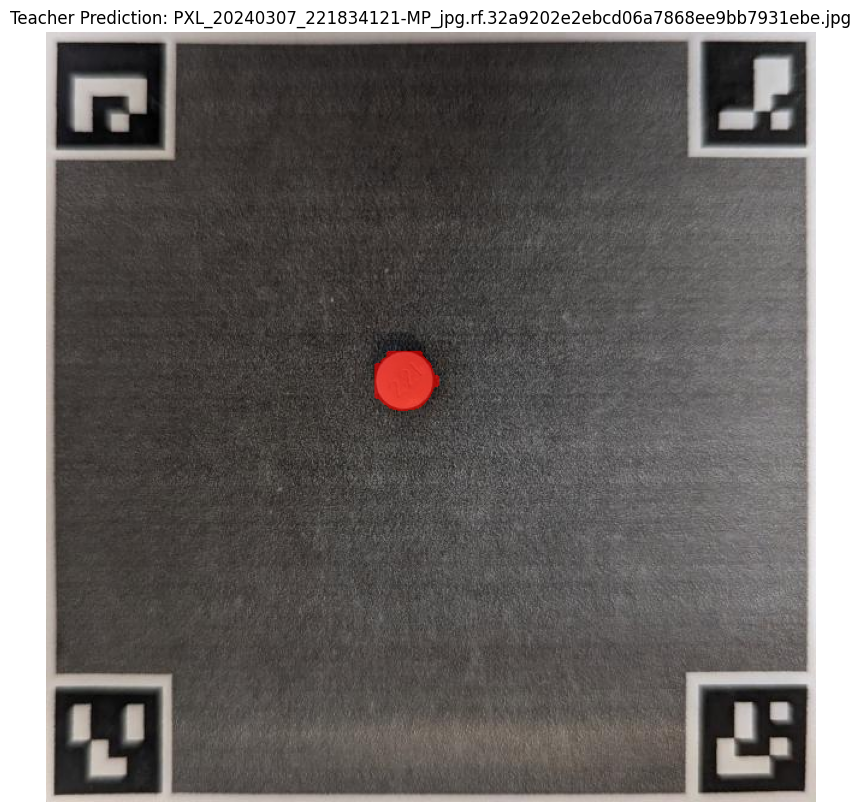

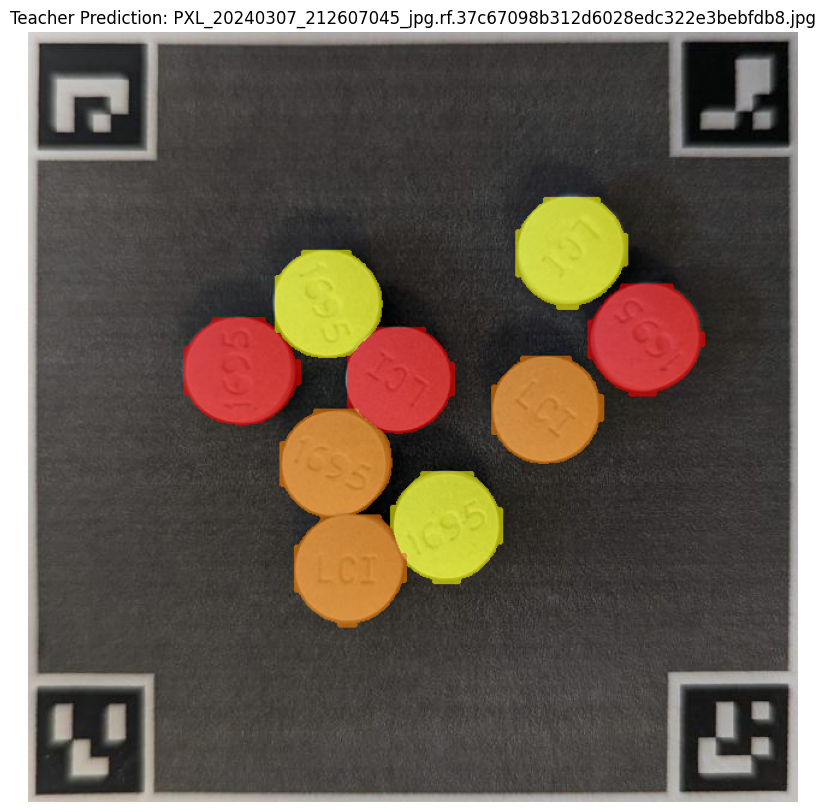

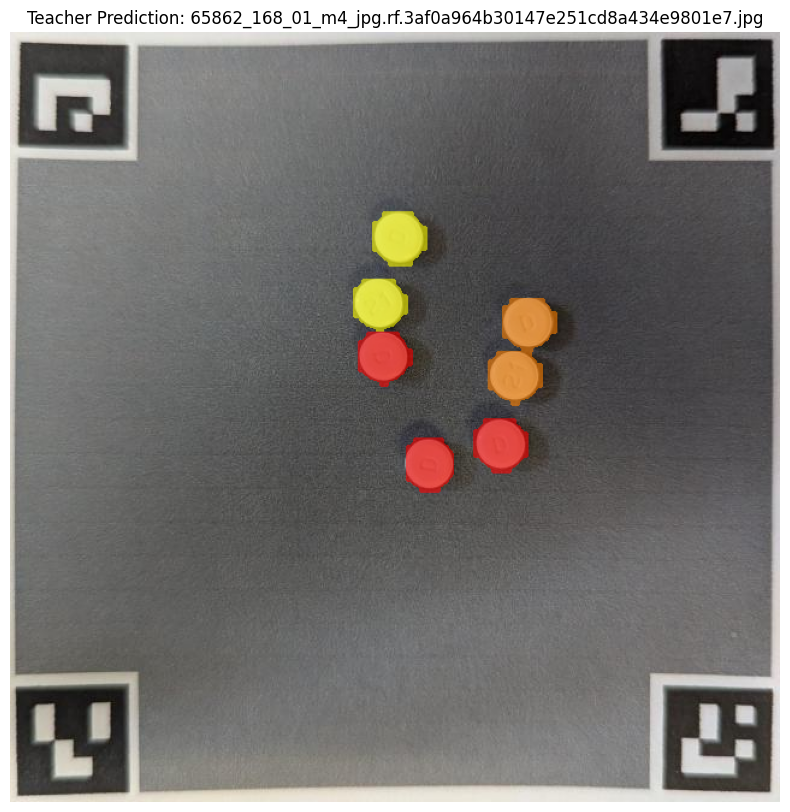

In [8]:
import matplotlib.pyplot as plt
import random
import cv2  
import numpy as np
import glob

def plot_bright_masks(model, img_path, alpha=0.6):
    img = cv2.imread(img_path)
    if img is None: return
    
    # Run Prediction
    results = model.predict(img_path, verbose=False, conf=0.25)
    result = results[0]

    overlay = img.copy()
    
    # Red, Yellow, Orange Colors
    colors = [(0, 0, 255), (0, 255, 255), (0, 128, 255)]
    
    if result.masks is not None:
        for i, contour in enumerate(result.masks.xy):
            if len(contour) > 0:
                color = colors[i % len(colors)]
                cnt = contour.astype(np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [cnt], color)
                cv2.polylines(overlay, [cnt], isClosed=True, color=color, thickness=2)

        # Blend
        cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
        
        # Show
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Teacher Prediction: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ No masks found in {os.path.basename(img_path)}.")

# --- Load Best Teacher Model ---
print("Checking Teacher Segmentations on Test Data...")
best_teacher_vis = YOLO('mixmatch_project/teacher_run/weights/best.pt') 

# Test on 3 random images from the test set
test_images = glob.glob(os.path.join(ORIG_TEST_IMG, '*'))
samples = random.sample(test_images, 3)

for img_file in samples:
    plot_bright_masks(best_teacher_vis, img_file)

In [9]:
# --- MixMatch Step 1: Label Guessing ---
print("--- Evaluating Teacher Performance ---")
# Ensure using the correct project path variable
PROJECT_NAME = 'mixmatch_project'
best_teacher = YOLO(f'{PROJECT_NAME}/teacher_run/weights/best.pt')

print(f"--- Generating Pseudo Labels ---")
print(f"Note: TTA (augment=True) disabled due to Segmentation model limitations.")

unlabeled_images_list = glob.glob(os.path.join(UNLABELED_DIR, 'images', '*'))
pseudo_count = 0

for img_path in tqdm(unlabeled_images_list):
   
    results = best_teacher.predict(
        img_path, 
        conf=MIXMATCH_THRESHOLD, 
        iou=0.6,
        augment=False, 
        verbose=False
    )
    result = results[0]
    
    basename = os.path.basename(img_path)
    txt_name = basename.rsplit('.', 1)[0] + '.txt'
    save_path = os.path.join(UNLABELED_DIR, 'labels', txt_name)
    
    # Save labels if masks are detected
    if result.masks is not None:
        with open(save_path, 'w') as f:
            for i, box in enumerate(result.boxes):
                cls = int(box.cls[0])
                segments = result.masks.xyn[i]
                line = f"{cls} " + " ".join([f"{coord:.6f}" for coord in segments.flatten()])
                f.write(line + "\n")
        pseudo_count += 1

print(f"MixMatch Guessing complete. {pseudo_count}/{len(unlabeled_images_list)} images labeled.")

--- Evaluating Teacher Performance ---
--- Generating Pseudo Labels ---
Note: TTA (augment=True) disabled due to Segmentation model limitations.


  0%|          | 0/5240 [00:00<?, ?it/s]

MixMatch Guessing complete. 5058/5240 images labeled.


In [10]:
print("Merging datasets for Student...")

# 1. Copy Original Labeled (20%)
for img in glob.glob(os.path.join(LABELED_DIR, 'images', '*')):
    shutil.copy(img, os.path.join(PSEUDO_DIR, 'images'))
for lbl in glob.glob(os.path.join(LABELED_DIR, 'labels', '*')):
    shutil.copy(lbl, os.path.join(PSEUDO_DIR, 'labels'))

# 2. Copy MixMatch Guessed Data 
pseudo_lbls = glob.glob(os.path.join(UNLABELED_DIR, 'labels', '*'))

for lbl in pseudo_lbls:
    if os.path.getsize(lbl) > 0:
        basename = os.path.basename(lbl)
        img_name_search = glob.glob(os.path.join(UNLABELED_DIR, 'images', basename.rsplit('.', 1)[0] + '.*'))
        if img_name_search:
            src_img = img_name_search[0]
            shutil.copy(lbl, os.path.join(PSEUDO_DIR, 'labels'))
            shutil.copy(src_img, os.path.join(PSEUDO_DIR, 'images'))

print(f"Student Dataset Ready. Total images: {len(glob.glob(os.path.join(PSEUDO_DIR, 'images', '*')))}")

# Create Student YAML
student_yaml = {
    'path': WORK_DIR,
    'train': os.path.join(PSEUDO_DIR, 'images'),
    'val': ORIG_VAL_IMG,
    'test': ORIG_TEST_IMG,
    'names': {0: 'pill'}
}
with open('student_data.yaml', 'w') as f:
    yaml.dump(student_yaml, f)

Merging datasets for Student...
Student Dataset Ready. Total images: 6367


In [11]:
print("Cleaning up GPU memory...")
if 'teacher_model' in globals(): del teacher_model
if 'best_teacher' in globals(): del best_teacher
if 'student_model' in globals(): del student_model
gc.collect()
torch.cuda.empty_cache()
print(f"GPU Memory Cleared.")

Cleaning up GPU memory...
GPU Memory Cleared.


In [12]:
# --- MixMatch Step 2: Training with MixUp ---
# The core of MixMatch is "MixUp": training on linear combinations of Labeled and Unlabeled data.
# We set mixup=0.8 to heavily enforce this behavior.

print("--- Starting Student Training (MixMatch Strategy) ---")

# 1. Clear cache
for cache_file in glob.glob(os.path.join(PSEUDO_DIR, 'labels', '*.cache')):
    if os.path.exists(cache_file): os.remove(cache_file)

# 2. Load Student
student_model = YOLO('yolov8m-seg.pt') 

# 3. Train Student
student_results = student_model.train(
    data='student_data.yaml',
    epochs=25,
    imgsz=img_size,
    batch=16,        
    patience=15,
    project='mixmatch_project',
    name='student_run',
    exist_ok=True,
    workers=0,      
    amp=False,      
    cache=False,    
    verbose=True,
    
    # --- MIXMATCH HYPERPARAMETERS ---
    augment=True,
    # High MixUp is the key definition of MixMatch
    mixup=0.8,         # 80% probability of mixing images (Linear Interpolation)
    mosaic=1.0,        # Standard mosaic to support MixUp
    copy_paste=0.1,    # Lower copy-paste (MixMatch relies more on global MixUp)
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    fliplr=0.5
    # --------------------------------
)
print("Student Training Finished.")

--- Starting Student Training (MixMatch Strategy) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=student_data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.8, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=student_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ove

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.966      0.979       0.98       0.94      0.966       0.98      0.981      0.911
Speed: 0.2ms preprocess, 13.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/mixmatch_project/student_run
Student Training Finished.


In [13]:
# --- Evaluation ---
print("--- Loading Best Weights for Evaluation ---")
best_teacher = YOLO('mixmatch_project/teacher_run/weights/best.pt')
best_student = YOLO('mixmatch_project/student_run/weights/best.pt')

print("\n--- Calculating Metrics on Test Set ---")
metrics_t = best_teacher.val(data='teacher_data.yaml', split='test', verbose=False)
metrics_s = best_student.val(data='student_data.yaml', split='test', verbose=False)

print("\n" + "="*60)
print(f"{'METRIC':<25} | {'TEACHER (20%)':<15} | {'MIXMATCH STUDENT':<15}")
print("-" * 60)
print(f"{'mAP@0.5 (Mask)':<25} | {metrics_t.seg.map50:<15.4f} | {metrics_s.seg.map50:<15.4f}")
print(f"{'mAP@0.5:0.95 (Mask)':<25} | {metrics_t.seg.map:<15.4f}    | {metrics_s.seg.map:<15.4f}")
print("="*60 + "\n")

--- Loading Best Weights for Evaluation ---

--- Calculating Metrics on Test Set ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients
val: Fast image access ✅ (ping: 1.8±0.3 ms, read: 7.5±2.1 MB/s, size: 51.7 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 158.6it/s 1.9s0.0s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.4it/s 5.6s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.967      0.963      0.981      0.963       0.97      0.966      0.986      0.914
Speed: 2.0ms preprocess, 6.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/val
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.2±0.2 ms, read: 103.0±45.0 MB/s, size: 47.2 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 810.1it/s 0.4s0.1s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P   

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.972       0.98      0.979      0.945      0.975      0.983      0.982      0.913
Speed: 2.0ms preprocess, 13.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/runs/segment/val2

METRIC                    | TEACHER (20%)   | MIXMATCH STUDENT
------------------------------------------------------------
mAP@0.5 (Mask)            | 0.9864          | 0.9822         
mAP@0.5:0.95 (Mask)       | 0.9137             | 0.9126         



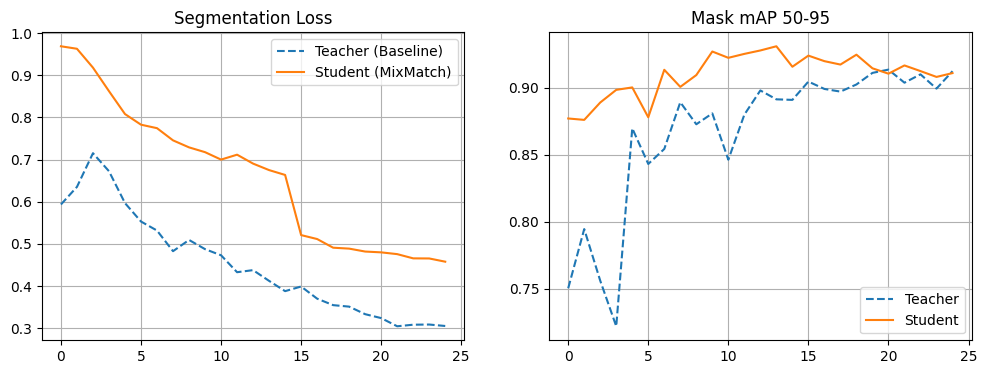

--- Visualizing Comparison: Teacher vs. MixMatch Student ---


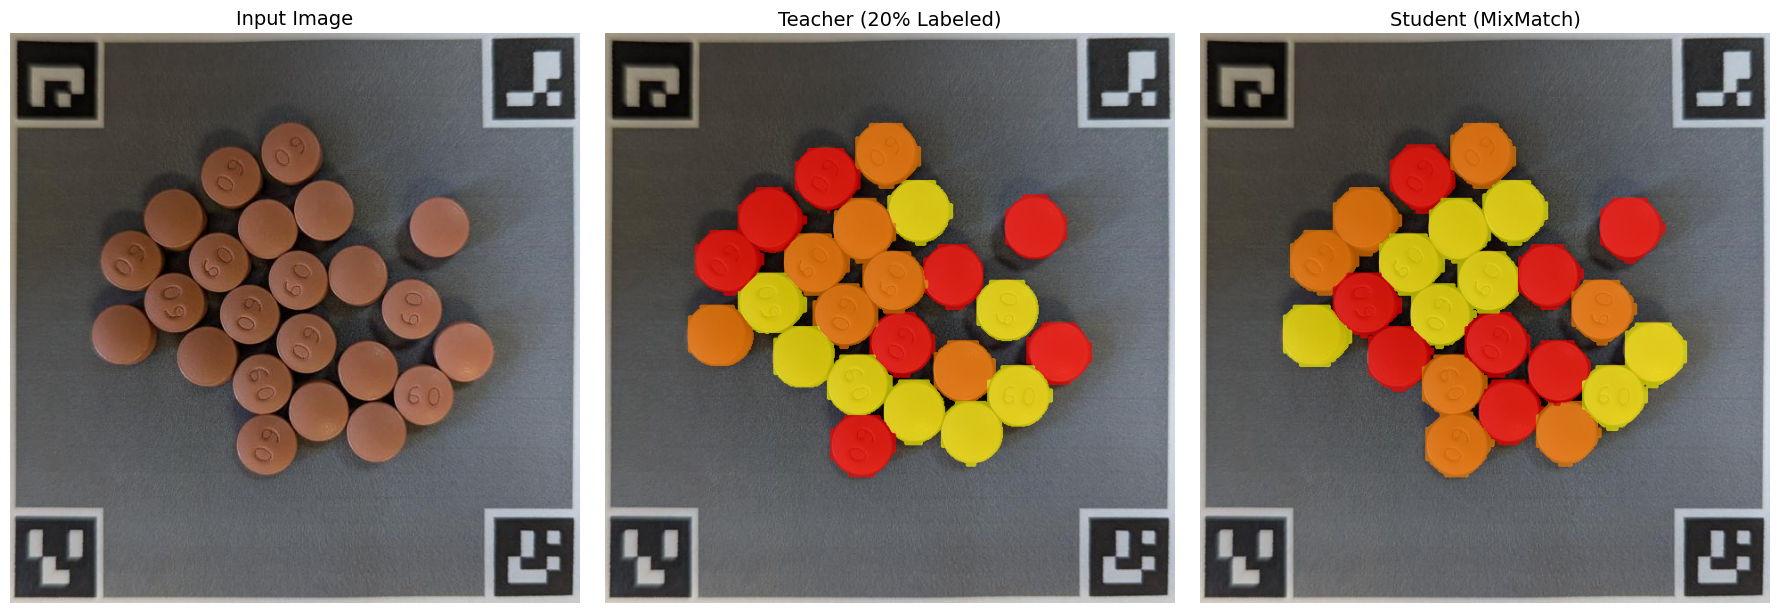

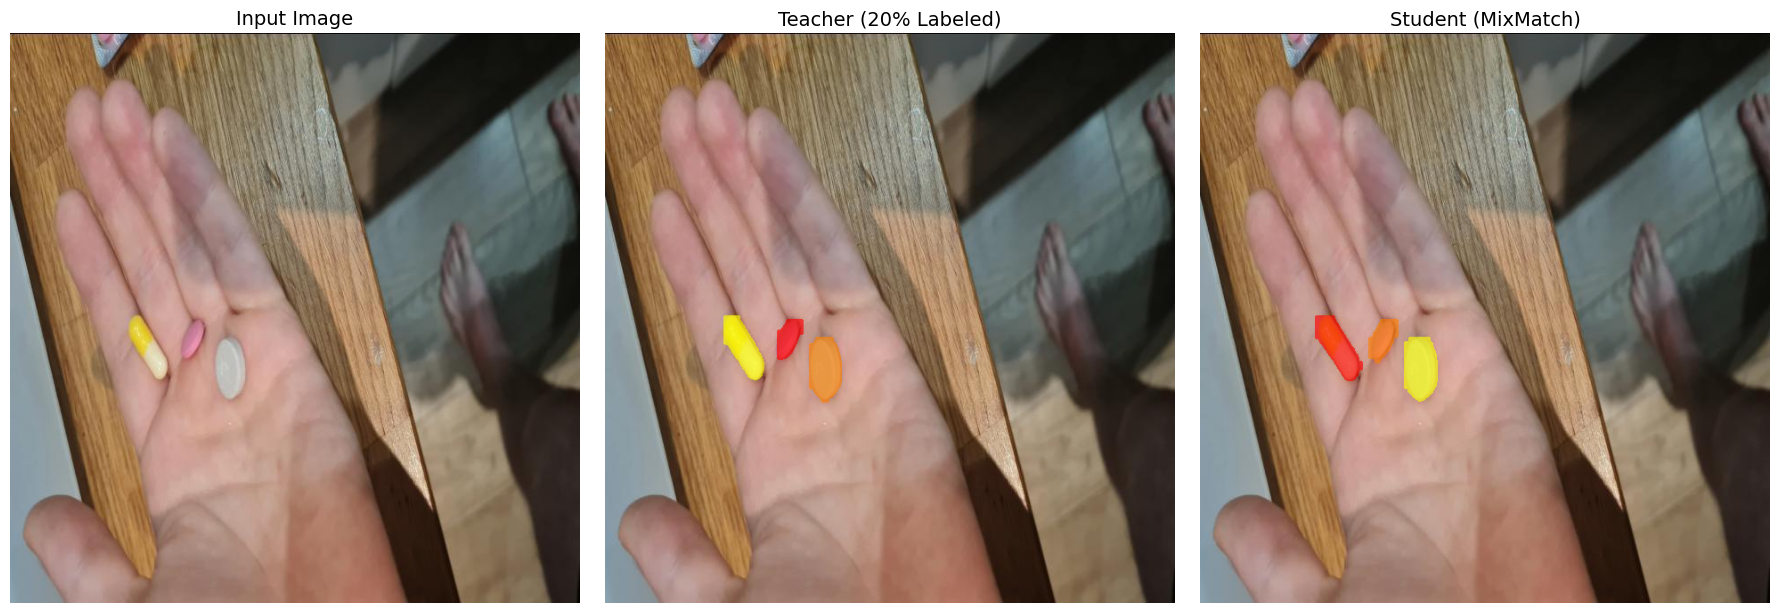

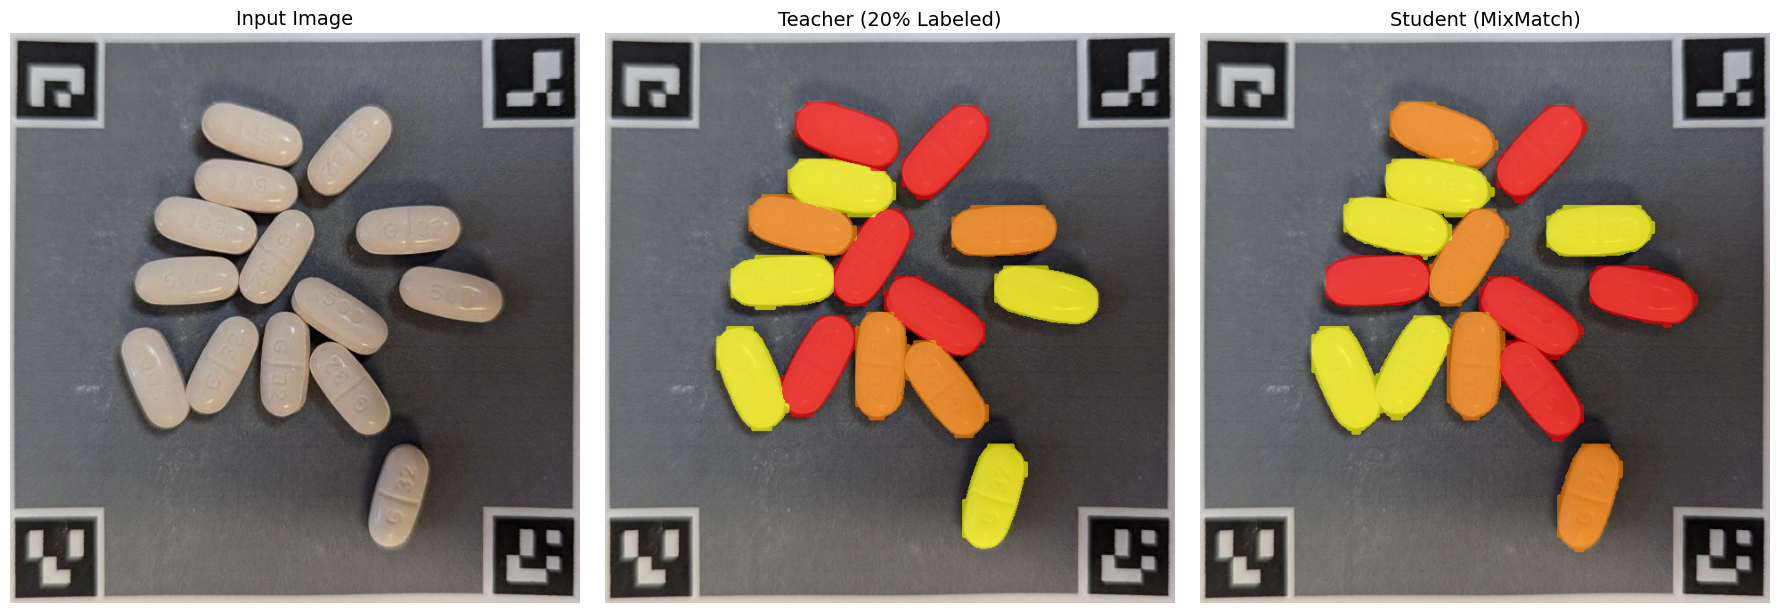

In [14]:
# --- Plot Loss Curves ---
try:
    t_df = pd.read_csv('mixmatch_project/teacher_run/results.csv')
    s_df = pd.read_csv('mixmatch_project/student_run/results.csv')
    t_df.columns = t_df.columns.str.strip()
    s_df.columns = s_df.columns.str.strip()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t_df['train/seg_loss'], label='Teacher (Baseline)', linestyle='--')
    plt.plot(s_df['train/seg_loss'], label='Student (MixMatch)')
    plt.title('Segmentation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_df['metrics/mAP50-95(M)'], label='Teacher', linestyle='--')
    plt.plot(s_df['metrics/mAP50-95(M)'], label='Student')
    plt.title('Mask mAP 50-95')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot loss curves: {e}")

# --- Visual Comparison Function ---
def get_colored_mask_image(model, img_path):
    img = cv2.imread(img_path)
    if img is None: return np.zeros((640,640,3), dtype=np.uint8)
    
    # Standard Inference for Viz
    results = model.predict(img_path, verbose=False, conf=0.25)
    result = results[0]
    overlay = img.copy()
    colors = [(0, 0, 255), (0, 255, 255), (0, 128, 255)]
    
    if result.masks is not None:
        for i, contour in enumerate(result.masks.xy):
            if len(contour) > 0:
                color = colors[i % len(colors)]
                cnt = contour.astype(np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [cnt], color)
                cv2.polylines(overlay, [cnt], isClosed=True, color=color, thickness=2)
    
    cv2.addWeighted(overlay, 0.65, img, 0.35, 0, img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("--- Visualizing Comparison: Teacher vs. MixMatch Student ---")
test_samples = glob.glob(os.path.join(ORIG_TEST_IMG, '*'))
samples = random.sample(test_samples, 3)

for img_path in samples:
    orig_img = cv2.imread(img_path)
    orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    teacher_vis = get_colored_mask_image(best_teacher, img_path)
    student_vis = get_colored_mask_image(best_student, img_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(orig_rgb)
    axes[0].set_title("Input Image", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(teacher_vis)
    axes[1].set_title("Teacher (20% Labeled)", fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(student_vis)
    axes[2].set_title("Student (MixMatch)", fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

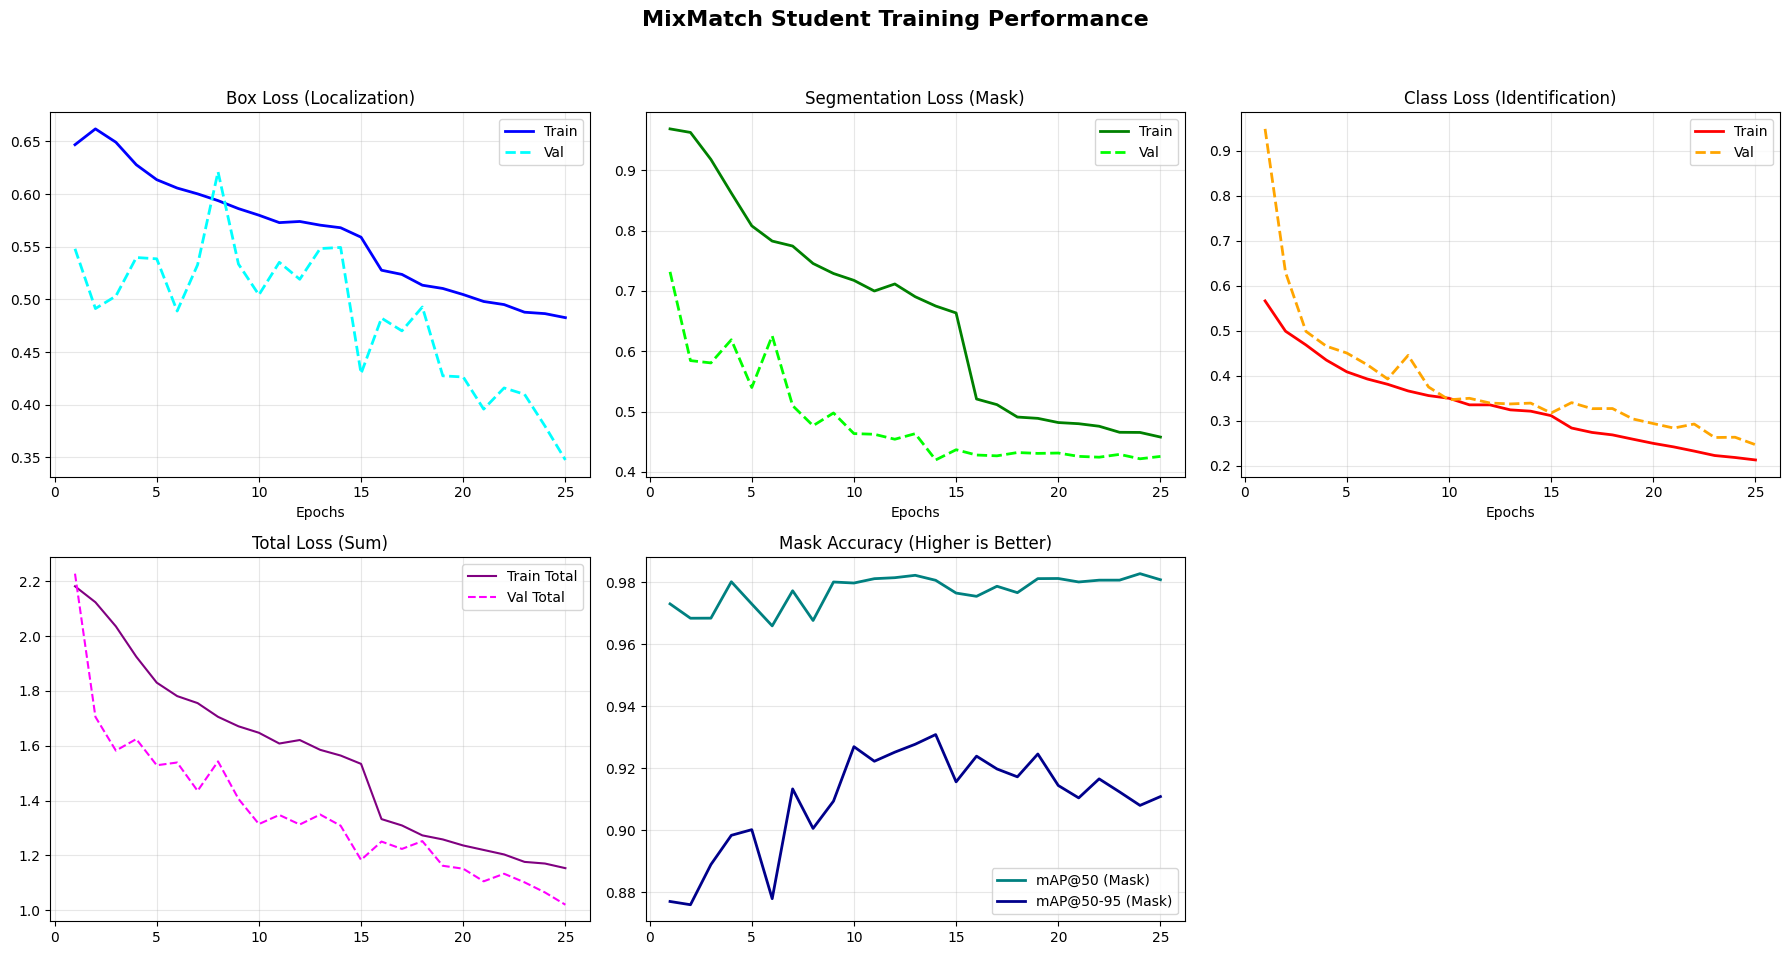


--- Latest Epoch Statistics ---
Epoch: 25
Mask mAP@50:    0.9808
Mask mAP@50-95: 0.9108


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- ⚙️ CONFIGURATION ---
# Path to your MixMatch Student results
RESULTS_PATH = 'mixmatch_project/student_run/results.csv'

def plot_mixmatch_losses(csv_path):
    # 1. Check if file exists
    if not os.path.exists(csv_path):
        print(f"❌ Error: Could not find results file at {csv_path}")
        print("Wait for at least 1 epoch to finish before running this.")
        return

    # 2. Load Data
    try:
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip() # Clean column names
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return
    
    # 3. Calculate Total Loss (Sum of components)
    # sum the main losses to see overall stability
    if 'train/box_loss' in df.columns:
        df['train/total_loss'] = df['train/box_loss'] + df['train/seg_loss'] + df['train/cls_loss']
        df['val/total_loss'] = df['val/box_loss'] + df['val/seg_loss'] + df['val/cls_loss']

    # 4. Plotting
    epochs = df['epoch']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('MixMatch Student Training Performance', fontsize=16, fontweight='bold')

    # Helper function
    def plot_metric(ax, metric, title, c_train, c_val):
        if f'train/{metric}' in df.columns:
            ax.plot(epochs, df[f'train/{metric}'], label='Train', color=c_train, linewidth=2)
        if f'val/{metric}' in df.columns:
            ax.plot(epochs, df[f'val/{metric}'], label='Val', color=c_val, linestyle='--', linewidth=2)
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # --- Row 1: Losses ---
    plot_metric(axes[0, 0], 'box_loss', 'Box Loss (Localization)', 'blue', 'cyan')
    plot_metric(axes[0, 1], 'seg_loss', 'Segmentation Loss (Mask)', 'green', 'lime')
    plot_metric(axes[0, 2], 'cls_loss', 'Class Loss (Identification)', 'red', 'orange')

    # --- Row 2: Accuracy & Total ---
    # Total Loss
    if 'train/total_loss' in df.columns:
        axes[1, 0].plot(epochs, df['train/total_loss'], label='Train Total', color='purple')
        axes[1, 0].plot(epochs, df['val/total_loss'], label='Val Total', color='magenta', linestyle='--')
        axes[1, 0].set_title('Total Loss (Sum)')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # mAP (Accuracy) - 
    if 'metrics/mAP50(M)' in df.columns: # Mask mAP
        axes[1, 1].plot(epochs, df['metrics/mAP50(M)'], label='mAP@50 (Mask)', color='teal', linewidth=2)
        axes[1, 1].plot(epochs, df['metrics/mAP50-95(M)'], label='mAP@50-95 (Mask)', color='darkblue', linewidth=2)
        axes[1, 1].set_title('Mask Accuracy (Higher is Better)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()
    
    # Hide empty 6th plot if unused
    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 5. Print Best Epoch Stats
    if not df.empty:
        best_epoch = df.iloc[-1] # Usually the last one or you can pick best map
        print("\n--- Latest Epoch Statistics ---")
        print(f"Epoch: {int(best_epoch['epoch'])}")
        print(f"Mask mAP@50:    {best_epoch.get('metrics/mAP50(M)', 0):.4f}")
        print(f"Mask mAP@50-95: {best_epoch.get('metrics/mAP50-95(M)', 0):.4f}")

# Run it
plot_mixmatch_losses(RESULTS_PATH)